# Lagrangian particle tracking

Materials and particles that tend to follow ocean currents can be analyzed in terms of trajectories. These are simply computed by integrating velocities over time within a [Lagrangian framework](https://en.wikipedia.org/wiki/Lagrangian_and_Eulerian_specification_of_the_flow_field). 

In `Julia` this is easily done e.g. using the [IndividualDisplacements.jl](https://JuliaClimate.github.io/IndividualDisplacements.jl/dev/) package.

## 1. Software, Grid, And Background Map

In [1]:
include("helper_functions.jl")
using IndividualDisplacements
pth=dirname(pathof(IndividualDisplacements))
include(joinpath(pth,"../examples/helper_functions.jl"));

In [2]:
using OceanStateEstimation
OceanStateEstimation.get_ecco_velocity_if_needed() #download data if needed

function global_ocean_circulation(;k=1,ny=2)
  r_reset = 0.01 #fraction of the particles reset per month (0.05 for k<=10)

  #read grid and set up connections between subdomains
  γ=GridSpec("LatLonCap",MeshArrays.GRID_LLC90)
  Γ=GridLoad(γ;option="full")
  Γ=merge(Γ,NeighborTileIndices_cs(Γ))

  func=(u -> update_location_llc!(u,𝐷))
  Γ=merge(Γ,(; update_location! = func))

  #initialize u0,u1 etc
  𝑃,𝐷=set_up_FlowFields(k,Γ,ECCOclim_path);

  #add parameters for use in reset!
  tmp=(frac=r_reset, Γ=Γ)
  𝐷=merge(𝐷,tmp)

  return 𝑃,𝐷

end

𝑃,𝐷=global_ocean_circulation(k=20,ny=2); #grid etc

In [3]:
lon=[i for i=-179.:2.0:179., j=-89.:2.0:89.]
lat=[j for i=-179.:2.0:179., j=-89.:2.0:89.]

(f,i,j,w)=InterpolationFactors(𝐷.Γ,vec(lon),vec(lat))
λ=(lon=lon,lat=lat,f=f,i=i,j=j,w=w);

OceanDepth=Interpolate(𝐷.Γ.Depth,λ.f,λ.i,λ.j,λ.w)
OceanDepth=reshape(OceanDepth,size(lon));

## 2. Initialize Individuals

In [4]:
𝐷.🔄(𝑃,𝐷,0.0) #update velocity fields (here, to Dec and Jan bracketing t=0.0)

np=100
xy = init_global_randn(np,𝐷)
df=DataFrame(x=xy[1,:],y=xy[2,:],f=xy[3,:]) #initial positions

𝐼=Individuals(𝑃,df.x[1:np],df.y[1:np],df.f[1:np]) #Individuals data structure

fieldnames(typeof(𝐼))

(:📌, :🔴, :🆔, :🚄, :∫, :🔧, :𝑃, :𝐷, :𝑀)

## 3. Compute Trajectories

In [5]:
𝑇=(0.0,𝐼.𝑃.𝑇[2]) #first half of January
∫!(𝐼,𝑇) #mid-Dec to mid-Jan

for m=1:12
    𝐷.🔄(𝑃,𝐷,0.0) #update velocity fields
    ∫!(𝐼) #integrate forward by one more month
end

## 4. Post-Processing

In [6]:
add_lonlat!(𝐼.🔴,𝐷.XC,𝐷.YC)
𝐼.🔴[end-3:end,:]

,ID,x,y,fid,t,lon,lat
,Int64,Float64,Float64,Int64,Float64,Float64,Float64
1,97,27.4223,117.216,2,1.314e6,79.4223,-39.3793
2,98,48.6166,22.374,4,1.314e6,164.374,45.6813
3,99,128.559,6.93656,5,1.314e6,-121.063,-18.2811
4,100,151.598,32.1083,5,1.314e6,-95.8917,-38.4587


## 5. Plot Trajectories

In this example we simply map out individual positions (red to blue) over a map of ocean depth (log10).

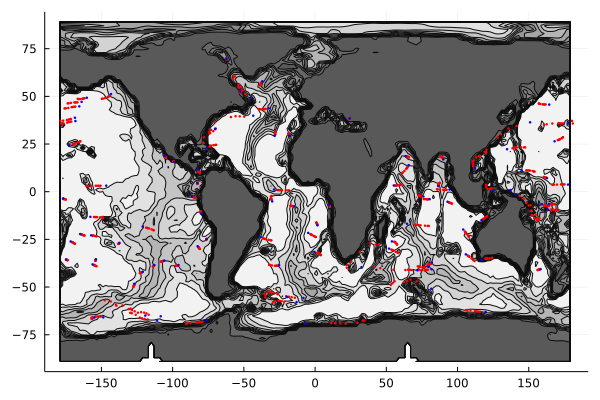

In [7]:
plt=contourf(vec(lon[:,1]),vec(lat[1,:]),permutedims(OceanDepth),clims=(-2500.,5000.),c = :grays, colorbar=false)
xli=extrema(lon)

🔴_by_t = groupby(𝐼.🔴, :t)
lo=deepcopy(🔴_by_t[1].lon); lo[findall(lo.<xli[1])]=lo[findall(lo.<xli[1])].+360
scatter!(lo,🔴_by_t[1].lat,markersize=1.5,c=:red,leg=:none,marker = (:circle, stroke(0)))
lo=deepcopy(🔴_by_t[end].lon); lo[findall(lo.<xli[1])]=lo[findall(lo.<xli[1])].+360
scatter!(lo,🔴_by_t[end].lat,markersize=1.5,c=:blue,leg=:none,marker = (:dot, stroke(0)))